# Random Forest notebook for images preprocessed with F. Civilini's pipeline

By Mariana Blanco-Rojas 2024

This notebook runs a random forest algorithm on the JMARS and Kaguya images acquired and preprocessed using F. Civilini's pipeline.
<br>

Overview of the workflow: <br>
<ul>
    <li> Read and save Kaguya tif file as pkl </li>
    <li> Read pkl data exported from JMARS </li>
    <li> Rotating and flipping JMARS data to match the orientation of Kaguya imagery </li>
    <li> Reading and rotating labeled map </li>
    <li> Resizing images </li>
    <li> Adding all data to a cube and saving labeled map </li>
    <li> Selecting points for training and validation </li>
    <li> Training and validating random forest on selected points </li>
    <li> Printing statistics from the validation results </li>
    <li> Running trained model on the entire image cube </li>
    <li> Plotting and saving labeled map map </li>

In [1]:
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import cm
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
from skimage.transform import resize
from matplotlib import ticker
import rasterio
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.ndimage import median_filter

In [2]:
# Function that resizes the image arrays before adding them to the data cube
def resize_array(array, target_shape):
    if isinstance(array, list):
        array = np.array(array)
    factors = [target_shape[i] / array.shape[i] for i in range(len(target_shape))]
    resized_array = zoom(array, factors, order=1)  # Using linear interpolation
    return resized_array

# Simple function to plot data
def plot_layer(data, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Function that converts a tif file (in this case the Kaguya TC imagery) to a pkl file
def tif_to_pkl(tif_path, pkl_path):
    with rasterio.open(tif_path) as src:
        data = src.read()
        metadata = src.meta

    # If desired, this prints the shape and type of the data for verification
    #print(f'tif file data shape: {data.shape}')
    #print(f'Read data type: {data.dtype}')
    #print(f'Read metadata: {metadata}')

    tif_data = {
        'data': data,
        'metadata': metadata
    }

    with open(pkl_path, 'wb') as f:
        pickle.dump(tif_data, f)

    print(f'TIFF data has been saved to {pkl_path} as PKL format.')

## 1. Making cube of pkl files

Clustering our data cubes
The directories we are taking data from are: ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
TIFF data has been saved to /explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya_test.pkl as PKL format.
raw_A17_div-hparam_512ppd_JMARS_interp.pkl has shape: (3, 431, 584)


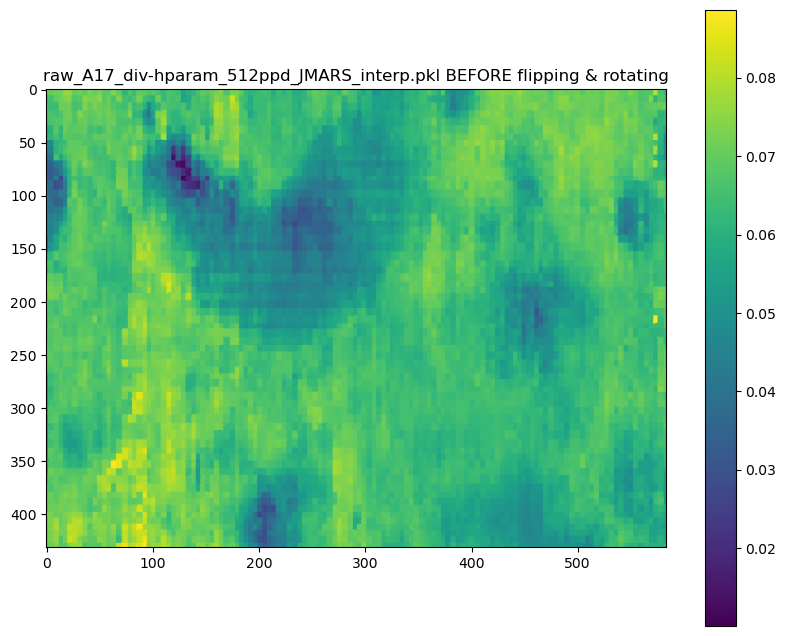

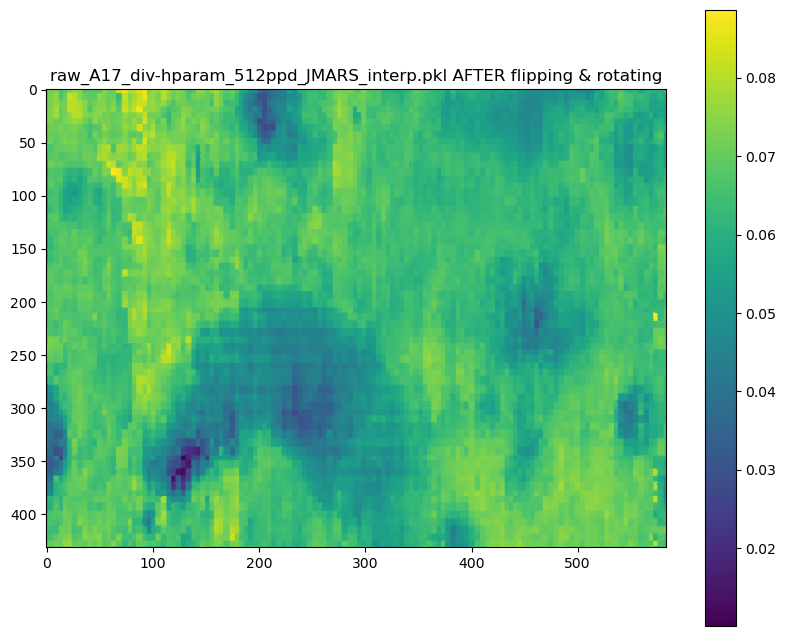

raw_A17_div-rockabun_2048ppd_JMARS_interp.pkl has shape: (3, 1798, 2354)


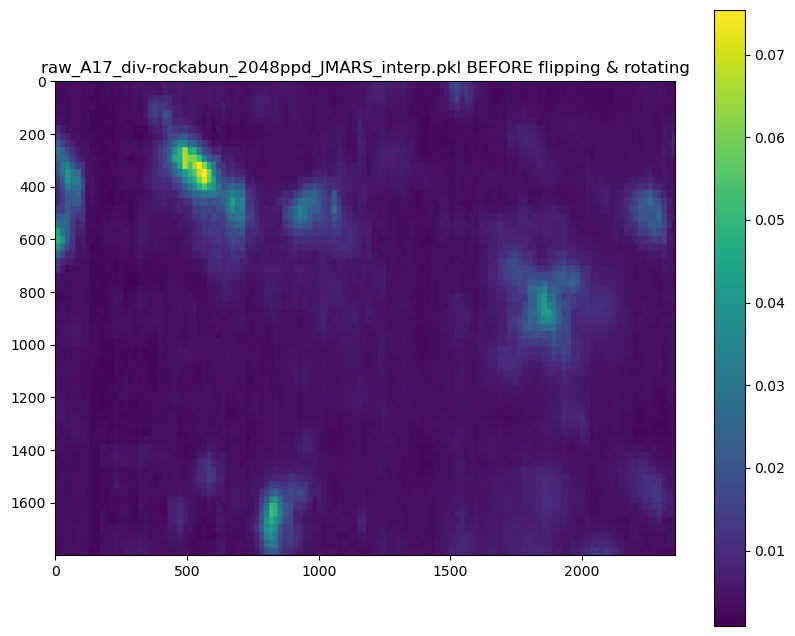

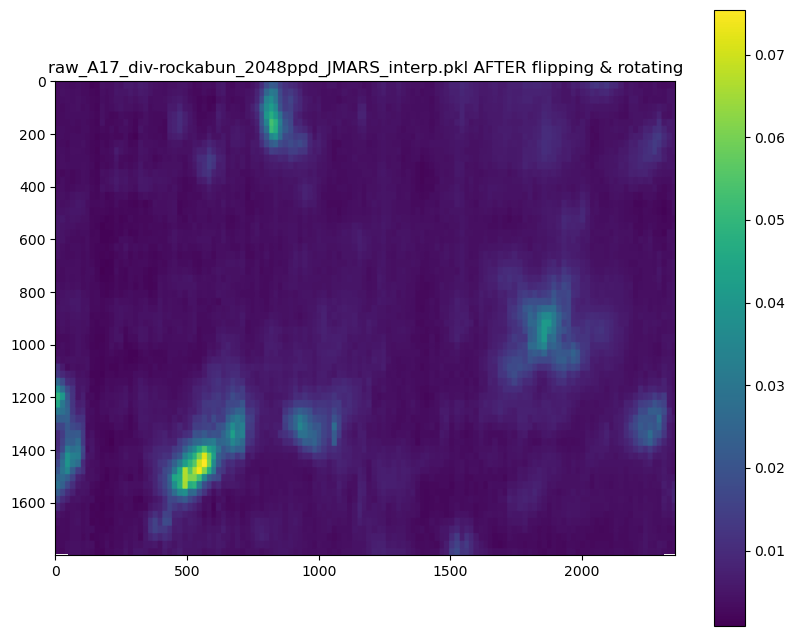

raw_A17_clem-omat_128ppd_JMARS_interp.pkl has shape: (3, 111, 148)


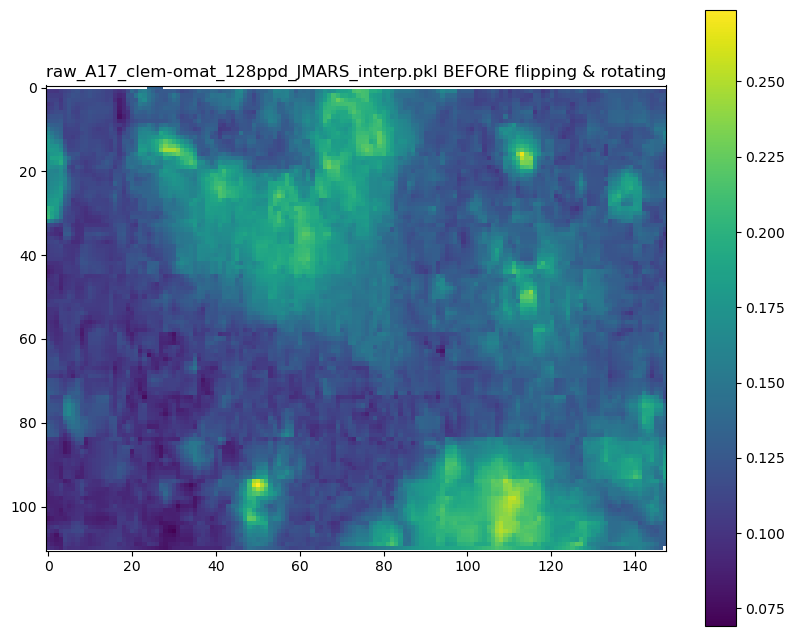

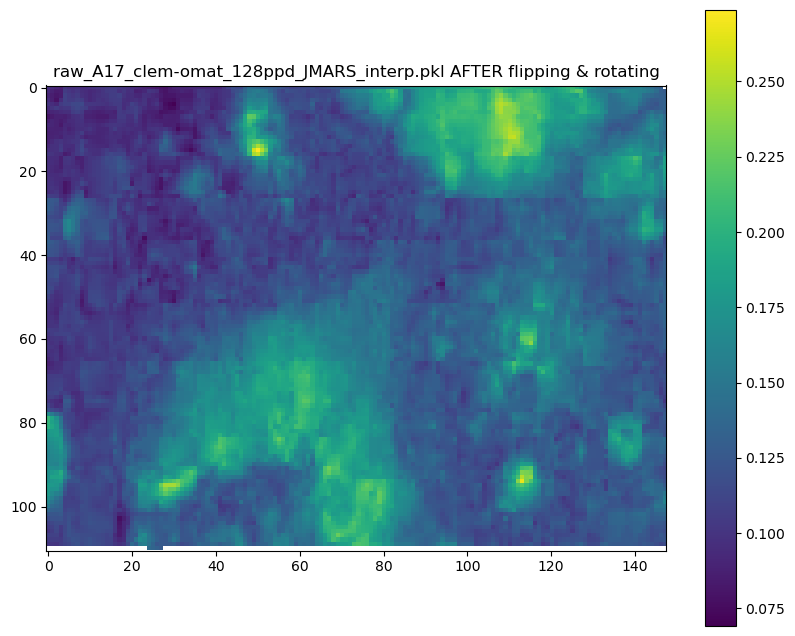

raw_A17_kaguya_test.pkl has shape: (3059, 6118)


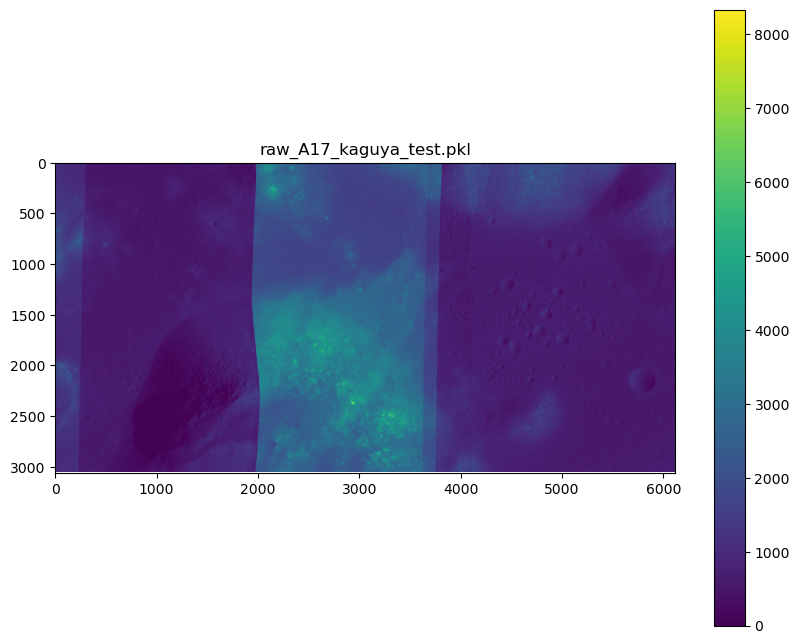

LABELS: (3, 52, 102)


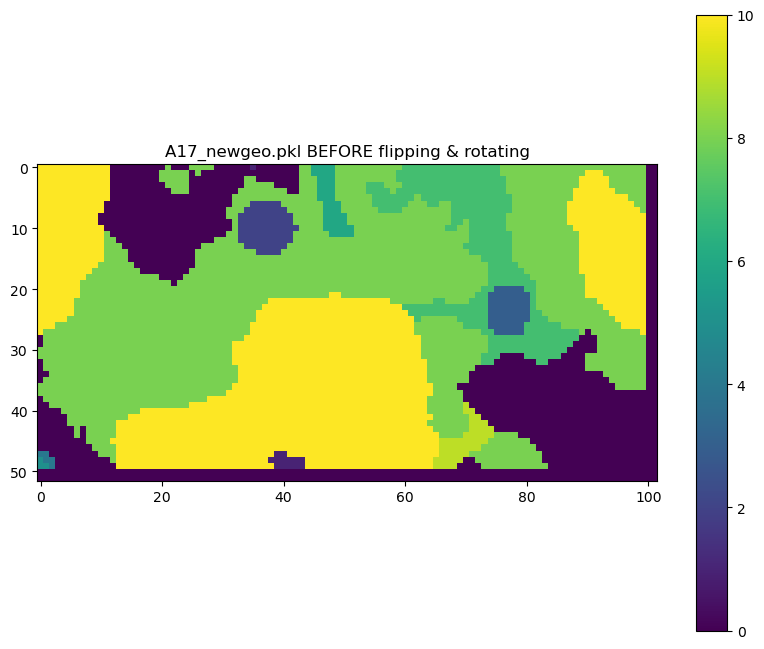

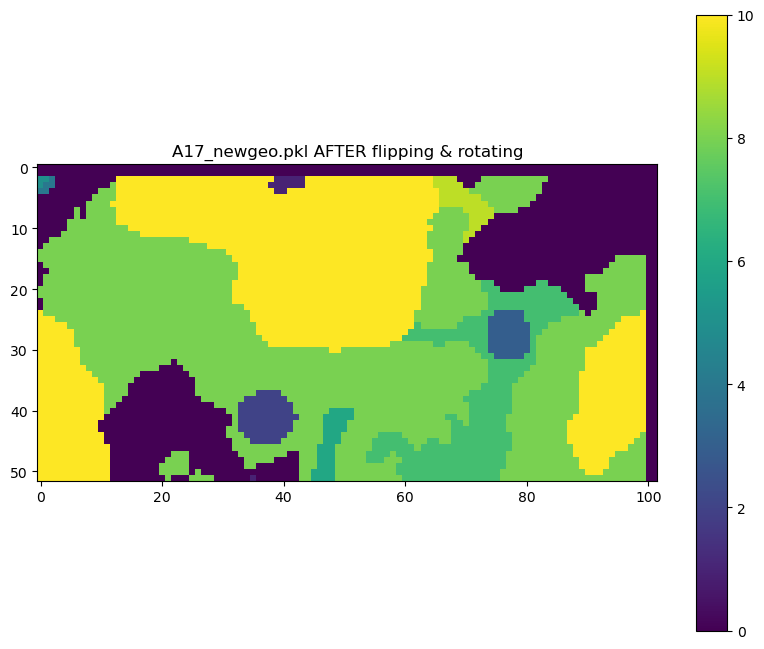

Data cube shape: (4, 3059, 6118, 1)
Made cube of pkl files


In [3]:
print('Clustering our data cubes')

# Directories where we have our cut JMARS and Kaguya data for the area of interest
directories = ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
print('The directories we are taking data from are:', directories)
max_shape = (0, 0, 0)
resized_data_all = []
pklcubes = []
pklfile_list = []

# Path for the tif file of the cut Kaguya data
tif_path = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya.tif'

# Path to save the pkl file of the cut Kaguya data
pkl_path = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya_test.pkl' 
tif_to_pkl(tif_path, pkl_path)

for directory in directories:
    # Load the .pkl files from the JMARS data
    for filename in os.listdir(directory):
        if filename.endswith('interp.pkl'):
            with open(os.path.join(directory, filename), 'rb') as f:
                data = pickle.load(f)
                print(filename, 'has shape:', np.shape(data))
                
                # Plotting cut data before flipping and rotating
                plot_layer(data[2][:][:], f'{filename} BEFORE flipping & rotating')
                
                # Rotating JMARS data by 180 degrees. We select to isolate layer 3, the only layer with data
                data = np.rot90(data[2][:][:], 2) 
                # Flipping JMARS data along the y axis
                data = np.fliplr(data)
                
                # Plotting data after it has been flipped and rotated
                plot_layer(data, f'{filename} AFTER flipping & rotating')
                
                pklfile_list.append(data)
                
                # Finding the largest dimension. This is what all arrays will be resized to
                max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(data)))

        # Load the .pkl file created from the Kaguya tif file
        if filename.endswith('test.pkl'):
            with open(os.path.join(directory, filename), 'rb') as f:
                data = pickle.load(f)
                data = data['data']
                data = np.squeeze(data)
                print(filename, 'has shape:', np.shape(data))
                
                plot_layer(data, f'{filename}')

                pklfile_list.append(data)
                
                # Finding the largest dimension. This is what all arrays will be resized to
                max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(data)))
                
        if filename.endswith('newgeo.pkl'):
            with open(os.path.join(directory, filename), 'rb') as f:
                data = pickle.load(f)
                print('LABELS:', np.shape(data))
               # Plotting cut data before flipping and rotating
                plot_layer(data[2][:][:], f'{filename} BEFORE flipping & rotating')
                data = data[2][:][:]
                
                # Rotating JMARS data by 180 degrees. We select to isolate layer 3, the only layer with data
                data = np.rot90(data, 2) 
                # Flipping JMARS data along the y axis
                data = np.fliplr(data)
                
                labels_layer = data
                
                label_data_height = np.shape(labels_layer)[0]
                label_data_width = np.shape(labels_layer)[1]
                
                # Plotting data after it has been flipped and rotated
                plot_layer(data, f'{filename} AFTER flipping & rotating')
                
                #pklfile_list.append(data)
                
                # Finding the largest dimension. This is what all arrays will be resized to
                max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(data)))
            

    # Resizing all images
    resized_data_list = [resize_array(data, max_shape) for data in pklfile_list]
    
    # Finding the scale factor for resizing the labeled map
    scale_factors = (max_shape[0] / label_data_height, max_shape[1] / label_data_width)

    # Resizing labeled map using nearest-neighbor interpolation
    resized_labels = zoom(labels_layer, scale_factors, order=0)
    
    resized_data_all.append(resized_data_list)

    # Combining the data into a single data cube 
    pklfile_cube = np.stack(resized_data_all, axis=-1)
    print(f'Data cube shape: {pklfile_cube.shape}')
    pklcubes.append(pklfile_cube)
    print('Made cube of pkl files')

## 2. Training setup:

In [4]:
# Selecting how many labels the image has and how many points we want to extract from each label for training and validation
labels_layer = resized_labels
selected_points = []
num_labels = 11
points_per_label = 250

unique_labels = np.unique(labels_layer)

In [5]:
assert len(unique_labels) == num_labels, "The layer must contain exactly 11 distinct labels."

### 2.1. Random Point Selection

In [6]:
# Selecting "points_per_label" random points per layer and saving the indeces
for label in unique_labels:
    # Get indices of all points with the current label
    indices = np.argwhere(labels_layer == label)
    
    selected_indices = indices[random.sample(range(len(indices)), points_per_label)]
    
    selected_indices = selected_indices[:, :2]
    
    # Add these selected points to the list
    selected_points.extend(selected_indices)
    
selected_points = np.array(selected_points)

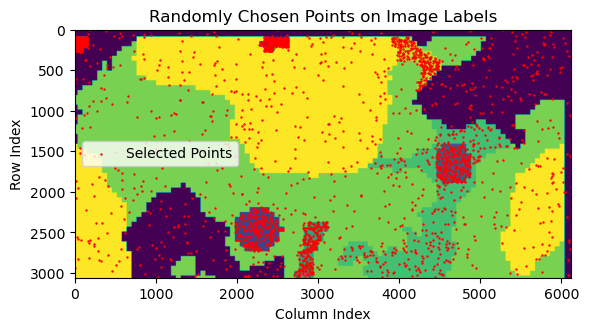

In [7]:
# "Coordinates" of points selected
rows = selected_points[:, 0]
cols = selected_points[:, 1]

# Plotting the points on top of the label map
plt.scatter(cols, rows, c='red', s=0.5, marker='o', label='Selected Points')
plt.imshow(labels_layer, cmap='viridis')

plt.legend()
plt.title('Randomly Chosen Points on Image Labels')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

plt.show()

### 2.2. Creating training and testing data

In [8]:
# Now we extract the values of pixels at each of the cube layers (features) and the label layer (labels)
features = []
labels = []

for point in selected_points:
    row, col = point
    
    # Extracting features from all layers at a given point
    feature_vector = pklfile_cube[:, row, col]
    features.append(feature_vector)
    
    # Extracting the label at a given point
    label = labels_layer[row, col]
    labels.append(label)

features = np.squeeze(features)    
features = np.array(features)
labels = np.squeeze(labels)
labels = np.array(labels)

In [9]:
height, width = np.squeeze(labels_layer).shape
total_pixels = height * width
testing_pixels = labels.size

training_size = (testing_pixels/total_pixels)*100

print('We are using', training_size, '% of the image pixels for training')

We are using 0.01469412548099216 % of the image pixels for training


In [10]:
# Dividing my data into training and testing, 
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [11]:
# Checking for NaNs
nan_mask = np.isnan(X_train)
print(f"Number of NaN values in X: {np.sum(nan_mask)}")

nan_indices = np.where(nan_mask)
print("Locations of NaN values in X:", nan_indices)

from sklearn.impute import SimpleImputer

# Filling NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Fitting the imputer to X and transforming the data
X_train = imputer.fit_transform(X_train)
X_val = imputer.fit_transform(X_val)

nan_mask = np.isnan(X_train)
print(f"Number of NaN values in X: {np.sum(nan_mask)}")

Number of NaN values in X: 17
Locations of NaN values in X: (array([ 213,  291,  417,  618,  851,  858, 1023, 1151, 1212, 1412, 1414,
       1507, 1558, 1817, 1958, 2010, 2118]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
Number of NaN values in X: 0


## 3. Setting up and training Random Forest 

In [12]:
hyperparameters = {'n_estimators': 400, 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                  }

In [13]:
rf_model = RandomForestClassifier(**hyperparameters)

In [15]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 1.46 s, sys: 181 ms, total: 1.64 s
Wall time: 555 ms


RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42,
                       warm_start=True)

### 3.1. Statistics

In [16]:
score = rf_model.score(X_val, y_val)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.8


In [17]:
# Predicting on the validation data
y_val_pred = rf_model.predict(X_val)

# Evaluating the model using accuracy score and classification report
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_report)

Validation Accuracy: 0.8000
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.54      0.60        50
         1.0       0.98      0.98      0.98        59
         2.0       0.78      0.87      0.82        46
         3.0       0.87      0.92      0.89        49
         4.0       0.98      0.96      0.97        56
         5.0       0.94      0.98      0.96        45
         6.0       0.85      0.85      0.85        55
         7.0       0.49      0.61      0.54        38
         8.0       0.55      0.39      0.46        54
         9.0       0.93      0.98      0.96        55
        10.0       0.56      0.63      0.59        43

    accuracy                           0.80       550
   macro avg       0.78      0.79      0.78       550
weighted avg       0.80      0.80      0.80       550



In [18]:
height, width = np.squeeze(labels_layer).shape

# Reshaping the cube to have all pixels as a separate sample (rows x features)
reshaped_cube = pklfile_cube.reshape(pklfile_cube.shape[0], -1).T

reshaped_cube = imputer.fit_transform(reshaped_cube)

# Predicting labels for all pixels in the cube
predicted_labels_flat = rf_model.predict(reshaped_cube)

# Reshaping the flat predictions back to the original image dimensions
predicted_labels = predicted_labels_flat.reshape(height, width)

## 4. Visualizing and saving predictions:

Saved predicted labels as: /explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/RandomForest/A17/PredictedLabels_08-13.png


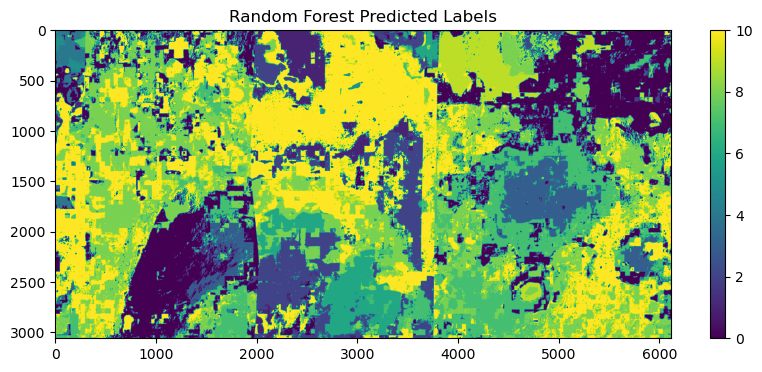

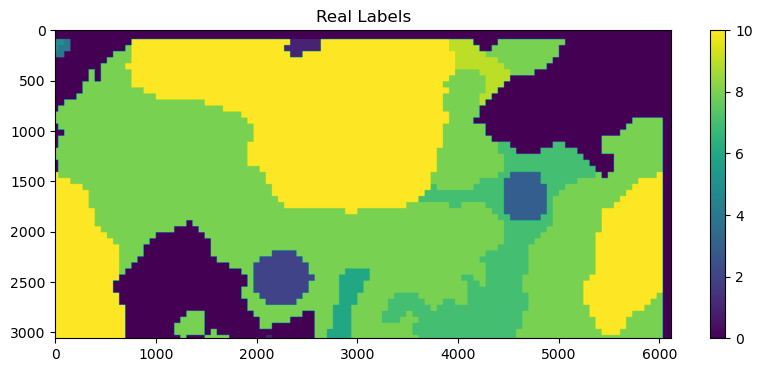

In [19]:
# Visualizing and saving predictions
directory = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/RandomForest/A17/'
if not os.path.exists(directory):
    os.makedirs(directory)

plt.figure(figsize=(10, 4)) 
plt.imshow(predicted_labels, cmap='viridis')
plt.colorbar()
plt.title("Random Forest Predicted Labels")
output_path = directory + 'PredictedLabels_08-13.png'
plt.savefig(output_path)
print('Saved predicted labels as:', output_path)
plt.show()

# Saving the predicted labels
with open('predicted_labels.pkl', 'wb') as f:
    pickle.dump(predicted_labels, f)
    
# Visualizing label map for comparison
plt.figure(figsize=(10, 4)) 
plt.imshow(labels_layer, cmap='viridis')
plt.colorbar()
plt.title("Real Labels")
plt.show()